In [6]:
!pip install watermark
!pip install pandas
!pip install polars 
!pip install numpy
!pip install yfinance
!pip install pyarrow
!pip install matplotlib

     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.6 MB 660.6 kB/s eta 0:00:12
      --------------------------------------- 0.1/7.6 MB 819.2 kB/s eta 0:00:10
     - -------------------------------------- 0.2/7.6 MB 1.2 MB/s eta 0:00:06
     - -------------------------------------- 0.3/7.6 MB 1.3 MB/s eta 0:00:06
     - -------------------------------------- 0.4/7.6 MB 1.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.4/7.6 MB 1.4 MB/s eta 0:00:06
     -- ------------------------------------- 0.5/7.6 MB 1.5 MB/s eta 0:00:05
     --- ------------------------------------ 0.6/7.6 MB 1.6 MB/s eta 0:00:05
     --- ------------------------------------ 0.7/7.6 MB 1.5 MB/s eta 0:00:05
     --- ------------------------------------ 0.7/7.6 MB 1.5 MB/s eta 0:00:05
     ---- ----------------------------------- 0.8/7.6 MB 1.5 MB/s eta 0:00

In [8]:
!pip install joblib

  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [9]:
# import the necessary libraries

from watermark import watermark
import sys
import os
import platform
from os.path import exists

import pandas as pd
import polars as pl    # using Polars DataFrame library for Rust and Python
import numpy as np
import yfinance as yf
import pyarrow as pa  #  pyarrow library to convert pandas dataframe to arrow format, to then convert it to a polars dataframe

import matplotlib.pyplot as plt


# import sklearn as sk
# from pathlib import Path
# import opendatasets as od
# import gzip


# from pandas.tseries.offsets import DateOffset

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.decomposition import PCA

# from sklearn.model_selection import cross_val_score
# from sklearn.svm import LinearSVC                       #  Linear Support Vector Classifier (SVC)
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import AdaBoostClassifier
# from xgboost.sklearn import XGBClassifier

# from sklearn import svm                                 #  support vector machine (SVM) learning method

# from sklearn.metrics import (classification_report, 
#                              balanced_accuracy_score, 
#                              confusion_matrix,
#                              roc_auc_score, 
#                              f1_score)

# from imblearn.metrics import classification_report_imbalanced

# import hvplot.pandas

# %matplotlib inline
# import seaborn as sns

import pickle                                          # method for save trained/fit model/s
import joblib                                          # method for save trained/fit model/s

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Report Technologies
print(f'Python Platform: {platform.platform()}')
print(f'Python {sys.version}')
print(watermark())
print(watermark(iversions=True, globals_=globals()))



Python Platform: Windows-10-10.0.22621-SP0
Python 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
Last updated: 2023-05-19T16:33:37.393928-05:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 104 Stepping 1, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

platform  : 1.0.8
pyarrow   : 12.0.0
sys       : 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
numpy     : 1.24.3
yfinance  : 0.2.18
matplotlib: 3.7.1
pandas    : 2.0.1
joblib    : 1.2.0
polars    : 0.17.14



define a function to retrieve and preprocess the data using yfinance.
    function will download the data, rename the columns, and drop any missing values. 
    delete “adj close” column as unnecessary needed for analysis

In [11]:


# Block one

def preprocessing_yf(symbol):
    #Import the data
    df = yf.download(symbol).dropna()
    #Rename
    df.columns = ["open", "high", "low", "close", "adj close", "volume"]
    df.index.name = "time"

    # Remove adjusted close
    del df["adj close"]

    return df



Call function for desired asset dataframe creation, store dataframe in a variable named df.
Generate standardized dataframe for analysis.

In [12]:
# function call for asset
df = preprocessing_yf("EURUSD=X")
df



[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0
...,...,...,...,...,...
2023-05-15,1.085270,1.089206,1.084858,1.085270,0
2023-05-16,1.087370,1.090358,1.085670,1.087370,0
2023-05-17,1.086567,1.087548,1.081163,1.086567,0


In [13]:
# Create Simple moving average 30 days
df["SMA fast"] = df["close"].rolling(30).mean()

# Create Simple moving average 60 days
df["SMA slow"] = df["close"].rolling(60).mean()



In [14]:
# Create the buy or sell condition
condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

df.loc[condition_buy, "signal"] = 1
df.loc[condition_sell, "signal"] = -1



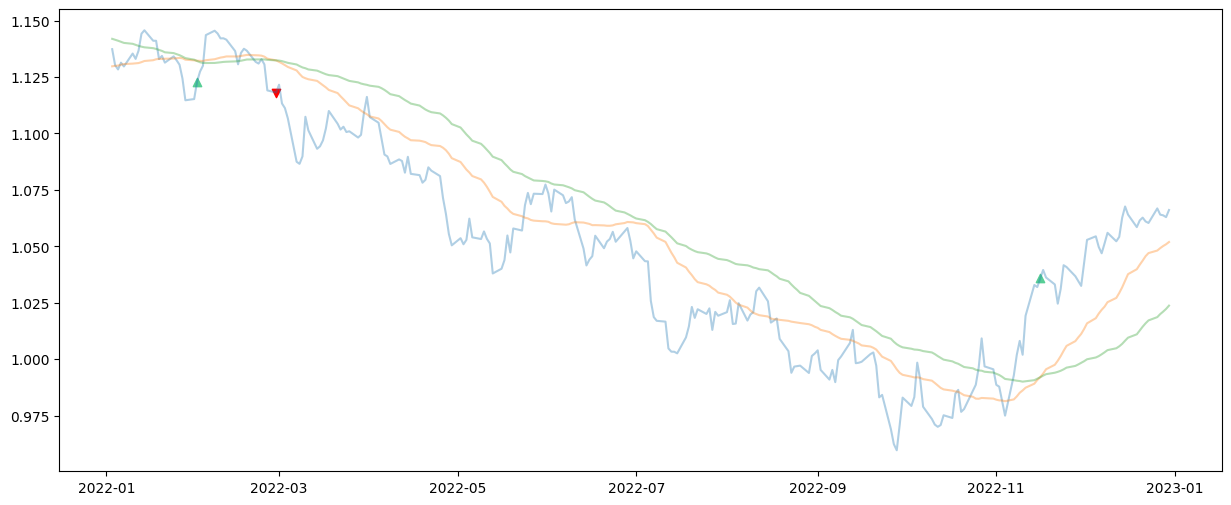

In [15]:
year="2022"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["signal"] == 1].loc[year].index
idx_close = df.loc[df["signal"] == -1].loc[year].index

# Adapt the size of the graph
plt.figure(figsize=(15,6))

# Plot the points of the open long signal in green and sell in red
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["close"].loc[year], color= "red", marker="v")

# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], alpha=0.35)
plt.plot(df["close"].loc[year].index, df["SMA fast"].loc[year], alpha=0.35)
plt.plot(df["close"].loc[year].index, df["SMA slow"].loc[year], alpha=0.35)

# Show the graph
plt.show()



In [16]:
# Create the position
df["position"] = df["signal"].fillna(method="ffill")

# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = (df["pct"] * df["position"].shift(1))



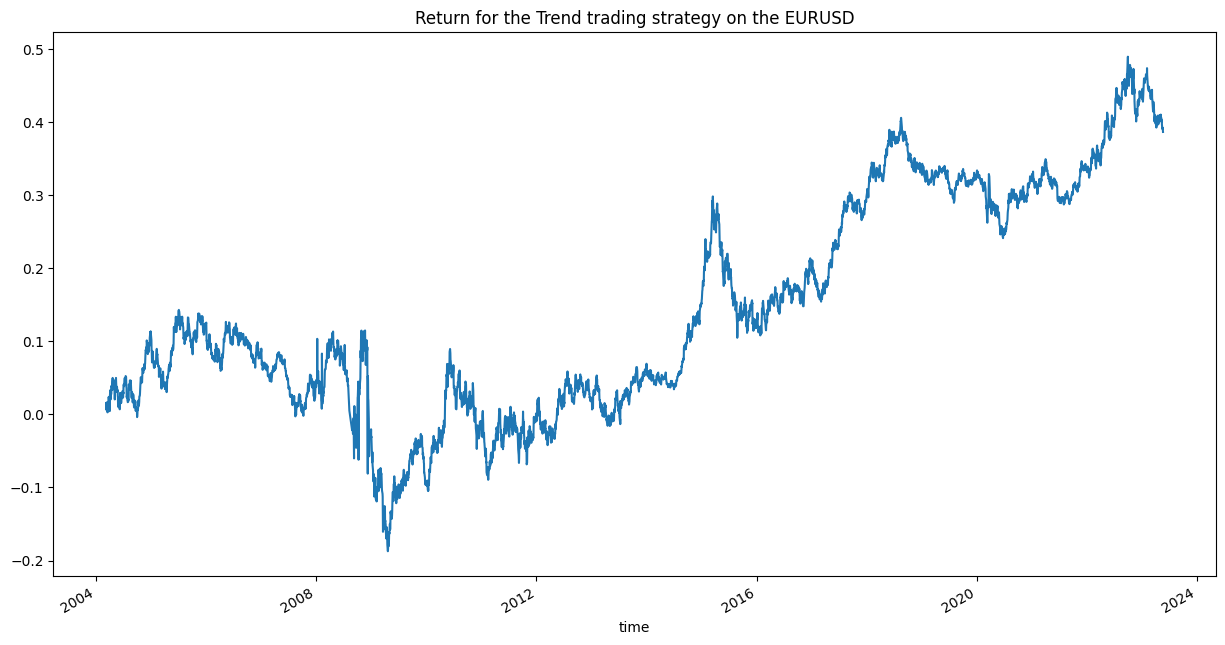

In [17]:
# We define a fix cost we need to pay each time we interact with the market
cost_ind = 0.0001

# We create a vector of cost
df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)

# Compute the return of the strategy with transaction cost
df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])

# Plot the cumulative return of the strategy
df["return"].cumsum().plot(figsize=(15,8), title="Return for the Trend trading strategy on the EURUSD")
plt.show()



In [18]:
# Define fast moving average, slow moving average, and cost index
fast_sma = 30
slow_sma = 60
cost_ind = 0.0001

def SMA_strategy(input, fast_sma, slow_sma, cost_ind):
    df = preprocessing_yf(input)

    # Create fast and slow moving averages
    df["SMA fast"] = df["close"].rolling(fast_sma).mean()
    df["SMA slow"] = df["close"].rolling(slow_sma).mean()

    # Create trading signals
    df["signal"]=np.nan
    condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
    condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))
    df.loc[condition_buy, "signal"] = 1
    df.loc[condition_sell, "signal"] = -1

    # Calculate the return of the strategy with transaction costs
    df["position"] = df["signal"].fillna(method="ffill")
    df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)
    df["pct"] = df["close"].pct_change(1)
    df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100

    # Return the cumulative return of the strategy
    return df["return"].cumsum()



[*********************100%***********************]  1 of 1 completed


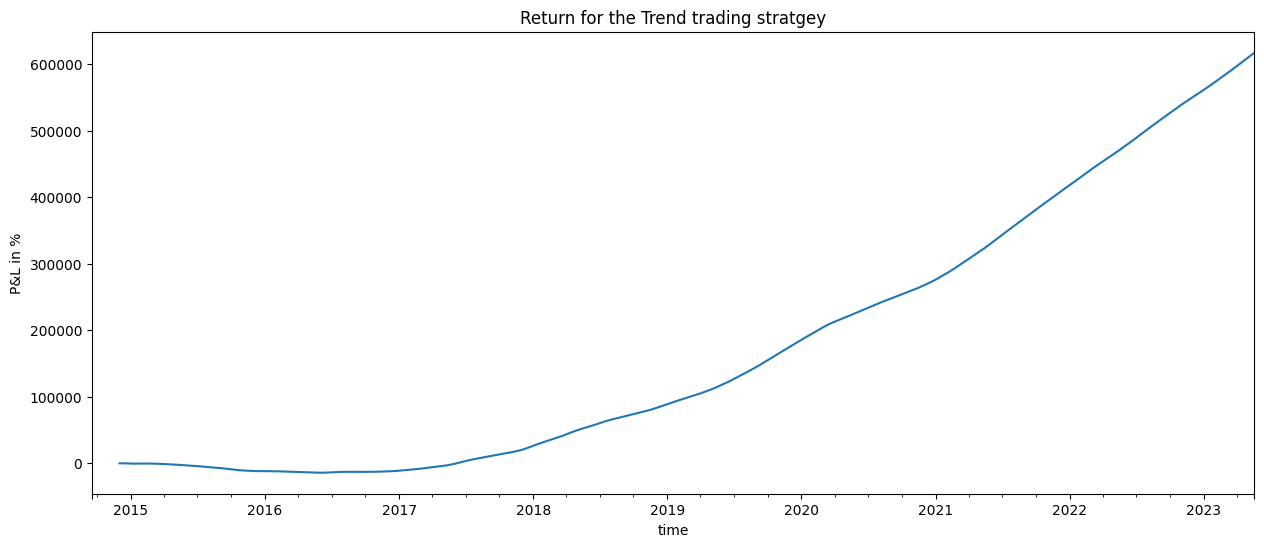

In [19]:
SMA_strategy("BTC-USD", 30,60, 0.0001).cumsum().plot(figsize=(15,6), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()

